In [1]:
import sympy as sy
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# ORIGINAL PARAMETERS #

y = 8.3e-5 #'' # units mup1 per millisecond (mup1 production rate)
w = 32 # unitless (scale factor for pH difference)
j = 100 #'' # per millisecond (methionine unbinding rate)
kd = 8993 # (methionine dissociation constant)
k = j / kd #'' # per micromolar per millisecond (methionine binding rate)
f = .25 #'' # per millisecond (recycling rate)
Ae = 47 # micrometers^3 (endosomal membrane surface area)
Ap = 314 # micrometers^3 (plasma membrane surface area)
a = 1 # per millisecond (ubiquitination rate)
h = 10 #'' # per micromolar per millisecond (art 1 binding rate)
b = 1 # per millisecond (deubiquitination rate)
z = .002 #'' # per millisecond (degradation rate)
g = 0.1 #'' # per millisecond (endocytosis rate)
V = 523 # micrometers^3 (volume of cytoplasm)
vmax = 174333.33 # micromolars*micrometers^3 per millisecond (maximal rate of methionine metabolism)
        # can range from 0 to infty
Km = 350 #'' # micromolars (methionin michaelis-menten constant)
# vmax = 8.8e3
# Km = 2.5
Me = .1


In [3]:
"""OLD PARAMETERS"""

# parameters (filled in the ones I think would be the same or similar to Fur4)
y = 8.3e-5 #'' # units mup1 per millisecond (mup1 production rate)
k = 100 / 8993 #'' # per micromolar per millisecond (methionine binding rate)
w = 32 # unitless (scale factor for pH difference)
j = 100 #'' # per millisecond (methionine unbinding rate)
f = .25 #'' # per millisecond (recycling rate)
Ae = 47 # micrometers^3 (endosomal membrane surface area)
Ap = 314 # micrometers^3 (plasma membrane surface area)
a = 1 # per millisecond (ubiquitination rate)
h = 1e-5 #'' # per micromolar per millisecond (art 1 binding rate)
b = 1 # per millisecond (deubiquitination rate)
z = .002 #'' # per millisecond (degradation rate)
g = 0.1 #'' # per millisecond (endocytosis rate)
V = 523 # micrometers^3 (volume of cytoplasm)
vmax = 8.8e3 #'' # micromolars*micrometers^3 per millisecond (maximal rate of methionine metabolism)
Km = 2.5 #'' # micromolars (methionine michaelis-menten constant)
Me = 1

In [4]:
# change a parameter
vmax = 174333.33
Km = 350
h = .65
j = 100
kd = 2188
k = j / kd


In [ ]:
# substitution into M to get equation for bisection method

# establish sympy variables
P, Pb, Pa, Pu, E, Em, Ea, Eu, M = sy.symbols("P, Pb, Pa, Pu, E, Em, Ea, Eu, M")

# steady states computed previously
steady_states = {P : y*w*(M*h**2*z*k + M*h*z*k*j + h**2*b*f*w + h**2*z*f*w + 2*h*b*f*j*w + 2*h*z*f*j*w + b*f*j**2*w + z*f*j**2*w)/(M*h**2*z*k**2*(M + Me*w)),
                 Pb : y*(M*h*z*k + h*b*f*w + h*z*f*w + b*f*j*w + z*f*j*w)/(M*h**2*z*k),
                 Pa : y*(M*h*z*k + h*b*f*w + h*z*f*w + b*f*j*w + z*f*j*w)/(M*h*z*k*a),
                 Pu : y*(M*h*z*k + h*b*f*w + h*z*f*w + b*f*j*w + z*f*j*w)/(M*h*z*k*g),
                 E : Ap*y*w*(h*b + h*z + b*j + z*j)/(Ae*M*h*z*k),
                 Em : Ap*y*(b + z)/(Ae*h*z),
                 Ea : Ap*y*(b + z)/(Ae*z*a),
                 Eu : Ap*y/(Ae*z)}

# substitutions
dM = -(k/w)*M*((Ap / V)*P + (Ae / V)*E) + (j + a)*((Ae / V)*Em + (Ap / V)*Pb) - vmax*M/(V*(Km + M))  # M 

new_dM = dM.subs(steady_states)
new_dM = sy.simplify(new_dM)
new_dM

(-174326.285240923*M**3 - 5385283.62994935*M**2 + 1826531394.96217*M + 615898623350.976)/(M*(523.0*M**2 + 199786.0*M + 5857600.0))

519.5723202778026


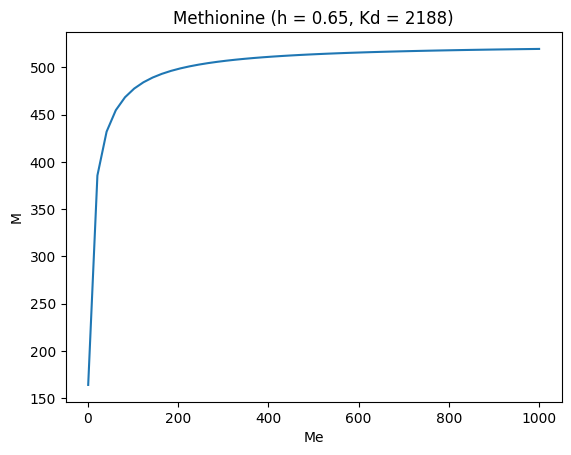

In [6]:
# dM_func = sy.lambdify(M, new_dM)

# # plot dM against M
# x_vals = np.linspace(0.001, 200, 1000)
# plt.plot(x_vals, dM_func(x_vals))
# plt.plot(x_vals, np.zeros_like(x_vals))
# plt.ylim(-100, 500)
# plt.show()

Me = sy.symbols("Me")

def bisection_M(m, dM=sy.lambdify(Me, (-Ap*M*y*(Km + M)*(M*y**2*z*k + M*h*z*k*j + h**2*b*f*w + h**2*z*f*w + 2*h*b*f*j*w + 2*h*z*f*j*w + h*k*(M + Me*w)*(h*b + h*z + b*j + z*j) + b*f*j**2*w + z*f*j**2*w) + Ap*y*(Km + M)*(M + Me*w)*(j + a)*(M*h*z*k + M*h*k*(b + z) + h*b*f*w + h*z*f*w + b*f*j*w + z*f*j*w) - M**2*h**2*z*k*vmax*(M + Me*w))/(M*V*h**2*z*k*(Km + M)*(M + Me*w))), 
                y=8.3e-5, k=135, w=32, j=100, f=.25, Ae=47, Ap=314, a=1,
                h=1e-5, b=1, z=.002, g=0.1, V=523, vmax=8.8e3, Km=2.5, bounds=[0, 4000], maxiter=10000):
    """Solving for the steady state of M at a given methionine value Me
        
        Parameters:
        - Me (float): amount of extracellular methionine
        - dM (sympy lambda function): differential equation in terms of extracellular methionine input as independent variable
        - parameters (floats, optional): set to the values we currently have, can be changed as needed
        - bounds (list, optional): initial upper and lower bound for the bisection method"""
    # save dM with substitutions for all other variables (computed in steady_states_simplification.ipynb)
    dM = sy.simplify(dM(m))
    dM_eq = sy.lambdify(M, dM)

    # assign variables for beginning, end, and midpoint
    x0, x1 = bounds[0], bounds[1]

    # use a loop to continue splitting the interval until you find 0
    for i in range(maxiter):
        # assign midpoint
        xmid = (x0 + x1) / 2    # so that it updates every time

        # check function at midpoint
        if np.isclose(dM_eq(xmid), 0):
            return xmid
        elif (dM_eq(xmid) > 0):   # if greater than zero, it should replace the left endpoint
            x0 = xmid
        else:                  # if less than zero, it should replace right endpoint
            x1 = xmid
    
    # raise runtime error if it doesn't converge
    print(m)
    raise RuntimeError(f"Failed to converge in {maxiter} steps")

# graph to see if it works for wide range of values
print(bisection_M(1000))

mvals = np.linspace(1, 1000, 50)
plt.plot(mvals, [bisection_M(m) for m in mvals])
plt.title(f"Methionine (h = {h}, Kd = {kd})")
plt.xlabel("Me")
plt.ylabel("M")
# plt.savefig(f"Images/varying_parameters/normal_except_h={h}_Kd={kd}.png")
plt.show()

In [ ]:
"""Define the model"""
from mup1_model import bisection_M

def mup1_model(t, y, parameters):
    """Function coding the Mup1 trafficking model.
    
        Parameters:
        - y (array, list): values of P, Pb, Pa, Pu, E, Em, Ea, Eu, M"""

    P, Pb, Pa, Pu, E, Em, Ea, Eu, M = y 
    y, w, j, kd, f, Ae, Ap, a, h, b, z, g, V, vmax, Km, Me = parameters    # unpack for readability
    k = j / kd

    # define the differential equations
    dy = [
        y - k*Me*P - (k/w)*M*P + j*Pb + f*(Ae/Ap)*E,                       # P
        k*Me*P + (k/w)*M*P - j*Pb - h*Pb,                                  # Pb
        h*Pb - a*Pa,                                                       # Pa
        a*Pa - g*Pu,                                                       # Pu
        g*(Ap/Ae)*Pu - f*E + b*Eu - (k/w)*E*M + j*Em,                      # E
        (k/w)*E*M - h*Em - j*Em,                                           # Em
        h*Em - a*Ea,                                                       # Ea
        -b*Eu + a*Ea - z*Eu,                                               # Eu
        -(k/w)*M*((Ap / V)*P + (Ae / V)*E) + (j + a)*((Ae / V)*Em + (Ap / V)*Pb) - vmax*M/(V*(Km + M))  # M 
        ]

    return dy

def mup1_steady_states(parameters):
    """Function to find the steady states of the Mup1 trafficking model.
    
        Parameters:
        - parameters (array, list): values of the parameters"""
    y, w, j, kd, k, f, Ae, Ap, a, h, b, z, g, V, vmax, Km, Me = parameters    # unpack for readability
    M = bisection_M(Me)

    steady_states = { 'P' : y*w*(M*h**2*z*k + M*h*z*k*j + h**2*b*f*w + h**2*z*f*w + 2*h*b*f*j*w + 2*h*z*f*j*w + b*f*j**2*w + z*f*j**2*w)/(M*h**2*z*k**2*(M + Me*w)),
                     'Pb' : y*(M*h*z*k + h*b*f*w + h*z*f*w + b*f*j*w + z*f*j*w)/(M*h**2*z*k),
                     'Pa' : y*(M*h*z*k + h*b*f*w + h*z*f*w + b*f*j*w + z*f*j*w)/(M*h*z*k*a),
                     'Pu' : y*(M*h*z*k + h*b*f*w + h*z*f*w + b*f*j*w + z*f*j*w)/(M*h*z*k*g),
                      'E' : Ap*y*w*(h*b + h*z + b*j + z*j)/(Ae*M*h*z*k),
                     'Em' : Ap*y*(b + z)/(Ae*h*z),
                     'Ea' : Ap*y*(b + z)/(Ae*z*a),
                     'Eu' : Ap*y/(Ae*z)}
    

    return sum(steady_states.values()) + M

In [8]:
"""AI suggested parameter ranges"""

parameter_ranges = [
    [8.3e-6, 8.3e-4],     # y: Mup1 production rate – production rates can vary over orders of magnitude due to transcriptional and translational regulation, environmental cues, and promoter strength.
    [10, 100],            # w: pH scale factor – this is a unitless scaling factor, and while its exact biological interpretation may vary, a range of 1 order of magnitude allows for exploratory analysis without being too speculative.
    [10, 1000],           # j: Methionine unbinding rate – binding and unbinding kinetics often vary by 1–2 orders of magnitude depending on temperature, affinity, and conformational state.
    [1000, 90000],        # kd: Dissociation constant – dissociation constants vary widely across protein-ligand systems; range chosen to reflect affinities from high (1 μM) to low (90 μM) binding strength.
    # k is derived from j/kd, so it should not be varied independently – vary j and kd instead
    [0.025, 2.5],         # f: Recycling rate – endosomal recycling rates can vary depending on the type of cargo, regulatory proteins, and metabolic state; 1 order of magnitude captures plausible biological fluctuation.
    [20, 100],            # Ae: Endosomal surface area – endosomal sizes (and hence surface areas) differ based on maturation stage and cell size; this range allows for ~5x variation while remaining realistic for yeast cells.
    [100, 1000],          # Ap: Plasma membrane surface area – reflects variability in yeast cell size; 3–10 μm diameter cells yield surface areas within this range.
    [0.1, 10],            # a: Ubiquitination rate – enzymatic tagging rates are context-dependent, influenced by E3 ligase concentration and substrate type; range spans 2 orders of magnitude.
    [1, 100],             # h: Art1 binding rate – ART protein interactions with transporters can vary widely depending on substrate conformation and signaling state; large range allows for nonlinearity exploration.
    [0.1, 10],            # b: Deubiquitination rate – affected by availability of deubiquitinases and substrate accessibility; same logic as for ubiquitination rate.
    [0.0002, 0.02],       # z: Degradation rate – protein degradation is generally slow, but this range captures variation due to stress conditions, proteasome targeting, or trafficking dynamics.
    [0.01, 1],            # g: Endocytosis rate – strongly regulated and responsive to signaling, nutrient levels, and surface cargo density; up to 100-fold variability is plausible.
    [200, 1000],          # V: Cytoplasmic volume – yeast cells range from ~30 to ~100 fL; cytoplasmic volume varies with cell cycle stage and environmental conditions.
    [1e4, 1e6],           # vmax: Max methionine metabolism rate – reflects possible differences in metabolic enzyme expression, post-translational regulation, and methionine flux capacity.
    [50, 1000],           # Km: Michaelis constant – Km values commonly vary across enzymes and contexts; this range includes both high-affinity (low Km) and low-affinity (high Km) scenarios.
    [0.1, 500],           # Me: Extracellular methionine concentration – based on reported yeast media compositions (from starvation up to rich media); range spans near-zero to saturating conditions.
]


parameter_ranges_2 = [[1e-6, 1e-3],   # y: mup1 production rate (y)
                      [10, 100],      # w: pH scale factor
                      [10, 1000],     # j: methionine unbinding rate
                      [1000, 100000], # kd: methionine dissociation constant
                      [0.01, 1],      # f: recycling rate
                      [10, 100],      # Ae: endosomal membrane surface area
                      [100, 1000],    # Ap: plasma membrane surface area
                      [0.1, 10],      # a: ubiquitination rate (a)
                      [1, 100],       # h: art1 binding rate (h)
                      [0.1, 10],      # b: deubiquitination rate
                      [1e-4, 0.01],   # z: degradation rate (z)
                      [0.01, 1],      # g: endocytosis rate (g)
                      [100, 1000],    # V: cytoplasmic volume
                      [1e4, 1e6],     # vmax: maximal methionine metabolism rate
                      [10, 1000],     # Km: methionine Michaelis-Menten constant
                      [.1, 500]       # Me: extracellular methionine
]



In [9]:
"""Parameter Sensitivity Analysis"""
from SALib.sample import saltelli, sobol as sobol_sample
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

# set up problem
problem = {
    'num_vars': 16,
    'names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'h', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me'],
    'bounds': parameter_ranges
}

# generate samples using Saltelli sampler
param_values = sobol_sample.sample(problem, 32)

# loop over sample inputs and run model
Y = np.zeros([param_values.shape[0]])

# set up for use with solve_ivp
# Choose initial conditions
y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]

# Time span for integration
t_span = (0, 50)
t_eval = np.linspace(*t_span, 10)

for i, X in enumerate(tqdm(param_values, desc="Running model")):
    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    # have it save the total amount of mup1
    Y[i] = sum(sol.y[:, -1])

# compute sensitivity indices using model outputs
Si = sobol.analyze(problem, Y)

Si.plot()
plt.show()


Running model:   0%|          | 0/1088 [00:00<?, ?it/s]

KeyboardInterrupt: 